In [127]:
import networkx as nx
import pandas as pd
import json
import time
import datetime
import dateutil
import numpy as np

     road_id  source_point_id  target_point_id  distance
0         27              850              849        70
1         28              850              851        49
2         29              851              850        46
3         30              851              852        80
4         31              852              851        50
..       ...              ...              ...       ...
969     2015             1208             1209       449
970     2016             1208             1210       279
971     2018             1210             1155        11
972     2019             1210             1209       220
973     2021             1155             1210        13

[974 rows x 4 columns]
    point_id location_id
0        159       DGA_D
1        160       DGA_I
2        850           2
3        851           3
4        852           5
..       ...         ...
85       989          84
86       998          93
87      1077         131
88      1186         184
89      1191     

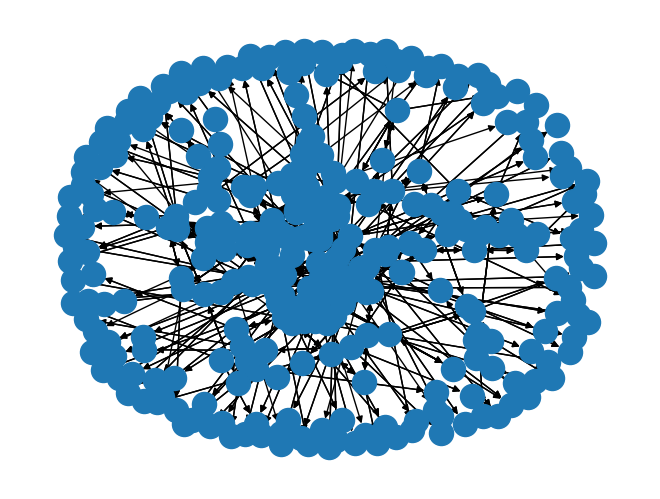

In [2]:
point_cloud_data = pd.read_excel('src/Distance.xlsx', sheet_name='Roads')
location_data = pd.read_excel('src/Distance.xlsx', sheet_name='Points')
print(point_cloud_data)
print(location_data)
di_grapth = nx.MultiDiGraph()
for i in range(point_cloud_data.shape[0]):
  row = point_cloud_data.iloc[i]
  di_grapth.add_edge(row['source_point_id'], row['target_point_id'], weight=row['distance'])
nx.draw(di_grapth)

In [205]:
def get_matrix_info(start, end):
  path = nx.shortest_path(di_grapth, start, end, 'weight')
  len = nx.shortest_path_length(di_grapth, start, end, 'weight')
  return path, len

def get_time_list(time_end, list_of_time):
  now_date = datetime.datetime.now().date()
  time_end = dateutil.parser.parse(time_end)
  time_end = datetime.datetime(now_date.year, now_date.month, now_date.day, time_end.hour, time_end.minute, time_end.second)
  start_time = []
  for time in list_of_time:
    start_time.append((time_end - datetime.timedelta(seconds=time)).strftime('%H:%M:%S'))
  return start_time

def get_specific_items(relevant_riders, size_people):
  relevant_riders_specific = []
  for rider in relevant_riders:
    if rider["size_people"] == size_people:
      relevant_riders_specific.append(rider)
  return relevant_riders_specific

def get_task_info(json_from_net):
  relevant_riders = []
  for rider in json_from_net['all_riders']:
    now_date = datetime.datetime.now().date()
    current_time = dateutil.parser.parse(json_from_net['current_time'])
    current_time = datetime.datetime(now_date.year, now_date.month, now_date.day, current_time.hour, current_time.minute, current_time.second)
    time_create_action = dateutil.parser.parse(json_from_net['tasks']['time_create_action'])
    time_create_action = datetime.datetime(now_date.year, now_date.month, now_date.day, time_create_action.hour, time_create_action.minute, time_create_action.second)
    if json_from_net['tasks']['fly_type_landing'] == "departure":
      path, len = get_matrix_info(json_from_net['tasks']['point_id'], rider['point_id'])
      time = int((15 + 30 + len / (1000 / 60))*60)
    elif json_from_net['tasks']['fly_type_landing'] == "arrival":
      path, len = get_matrix_info(json_from_net['tasks']['point_id'], rider['point_id'])
      time = int((15 + len / (1000 / 60) )*60)
    if current_time + datetime.timedelta(seconds=time) <= time_create_action:
      is_relevant = False
      if np.asarray(rider['all_tasks']).shape[0] == 0:
        is_relevant = True
      for task in rider['all_tasks']:
        time_end = dateutil.parser.parse(task['time_end'])
        time_end = datetime.datetime(now_date.year, now_date.month, now_date.day, time_end.hour, time_end.minute, time_end.second)
        if current_time + datetime.timedelta(seconds=time) > time_end:
          break
        elif current_time + datetime.timedelta(seconds=time) < time_end:
          is_relevant = True
      if is_relevant == True:
        relevant_riders.append(rider)
        relevant_riders[-1]['time'] = time

  airplane_capacity = json_from_net['tasks']['size_passenger']
  print(relevant_riders)
  iter_num = np.asarray(relevant_riders).shape[0]
  ids = []
  time_start_array = []
  for i in range(iter_num):
    if airplane_capacity >= 0:
      if airplane_capacity >= 100:
        specific_vehicle = get_specific_items(relevant_riders, 100)
        if np.asarray(specific_vehicle).shape[0] != 0:
          min_len_item = min(specific_vehicle, key=lambda x:x['time'])
          airplane_capacity = airplane_capacity - min_len_item['size_people']
          ids.append(min_len_item['id'])
          time_start_array.append(min_len_item['time'])
          relevant_riders.remove(min_len_item)
        else:
          specific_vehicle = get_specific_items(relevant_riders, 50)
          min_len_item = min(specific_vehicle, key=lambda x:x['time'])
          airplane_capacity = airplane_capacity - min_len_item['size_people']
          ids.append(min_len_item['id'])
          time_start_array.append(min_len_item['time'])
          relevant_riders.remove(min_len_item)
      if airplane_capacity <= 50:
          specific_vehicle = get_specific_items(relevant_riders, 50)
          if np.asarray(specific_vehicle).shape[0] != 0:
            min_len_item = min(specific_vehicle, key=lambda x:x['time'])
            airplane_capacity = airplane_capacity - min_len_item['size_people']
            ids.append(min_len_item['id'])
            time_start_array.append(min_len_item['time'])
            relevant_riders.remove(min_len_item)
          else:
            specific_vehicle = get_specific_items(relevant_riders, 100)
            min_len_item = min(specific_vehicle, key=lambda x:x['time'])
            airplane_capacity = airplane_capacity - min_len_item['size_people']
            ids.append(min_len_item['id'])
            time_start_array.append(min_len_item['time'])
            relevant_riders.remove(min_len_item)
      if airplane_capacity > 50 and airplane_capacity < 100:
        min_len_item = min(relevant_riders, key=lambda x:x['time'])
        airplane_capacity = airplane_capacity - min_len_item['size_people']
        ids.append(min_len_item['id'])
        time_start_array.append(min_len_item['time'])
        relevant_riders.remove(min_len_item)
    else:
      break

  for station in path:
    mastshrute = location_data.point_id[(location_data['point_id'] == station)].index
    if a.shape[0] != 0:
      path[path.index(station)] = f"{location_data.iloc[a[0]]['location_id']}"
    else:
      path[path.index(station)] = "null"
  print(ids)
  result = {
      'id': ids,
      'time_start': get_time_list(json_from_net['tasks']['time_create_action'], time_start_array),
      'time_end': json_from_net['tasks']['time_create_action'],
      'mastshrute': mastshrute,
      'tasks': json_from_net['tasks']
  }

  return result

In [188]:
path, len = get_matrix_info(850, 854)
for station in path:
  a = location_data.point_id[(location_data['point_id'] == station)].index
  if a.shape[0] != 0:
    path[path.index(station)] = f"{location_data.iloc[a[0]]['location_id']}"
  else:
   path[path.index(station)] = "none"
print(path)
print(len)

['2', '3', '5', '4D', '6']
195


In [207]:
with open("src/test.json", "r") as test_file:
  test = json.load(test_file)

text_data = get_task_info(test)
print(text_data)

[{'id': 'hyunday', 'point_id': 854, 'size_people': 50, 'all_tasks': [], 'time': 3402}, {'id': 'lada', 'point_id': 855, 'size_people': 50, 'all_tasks': [], 'time': 3556}, {'id': 'porsh', 'point_id': 853, 'size_people': 100, 'all_tasks': [], 'time': 3175}]
['porsh', 'hyunday']
{'id': ['porsh', 'hyunday'], 'time_start': ['10:37:05', '10:33:18'], 'time_end': '11:30:00', 'mastshrute': Int64Index([5], dtype='int64'), 'tasks': {'fly_type_landing': 'departure', 'point_id': 850, 'time_create_action': '11:30:00', 'size_passenger': 122}}
